# <center>Classifiers for Literacy Standard - Grades 5 and above</center>

<font style="font-variant:small-caps">Cornell-Farrow and Garrard</font> (2018). <i>A Machine Learning Approach for Detecting Students at Risk of Low Academic Achievement</i>. arXiv preprint. <a href='https://arxiv.org/abs/1807.07215'>arXiv:1807.07215</a>

This notebook contains the code used to generate the classifiers for predicting whether students fall into the 'below standard' band in the numeracy section of NAPLAN for grades 5 and above. IP for this data set is not held by the authors and so may not be uploaded together with this code in order to facilitate reproduction. Instructions for how the data set may be obtained are outlined in the README file.

This notebook was executed on an HPC cluster with 20 cpus. Executes in about 15 minutes. 
On an Intel i7 2.60GHz cpu runtime was about 40 minutes.


## Preprocessing

We begin by loading required packages and importing the data. The data are stored in a Stata .dta file.


In [1]:
library(readstata13)  # Importing data
library(ggplot2)      # Plotting
library(ggthemes)     # Themes for ggplot2
library(caret)        # Create training/test sets
library(rpart)        # Recursive partitioning decision tree classifier
library(rpart.plot)   # Plot the tree
library(pROC)         # Bulding ROC curves
library(DMwR)         # Constructing SMOTE sample
library(glmnet)       # Elastic net classifier
library(randomForest) # Random forest classifier
library(doMC)         # Run elastic net in parallel
library(parallel)

start.time <- Sys.time()

# Import data
raw.data <- read.dta13('NAPLAN_data.dta')


Loading required package: lattice
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: grid
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-13


Attaching package: ‘glmnet’

The following object is masked from ‘package:pROC’:

    auc

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: iterators
Loading required package: parallel


We now summarize the raw data and remove columns not to be used as predictors.

In [2]:
print('Raw data summary.')
dim(raw.data)
summary(raw.data)


[1] "Raw data summary."


[1] 2045434      39

    schoolid         priv          studentid            year       
 Min.   :   2   Min.   :0.0000   Min.   :      1   Min.   :0.0000  
 1st Qu.:2309   1st Qu.:0.0000   1st Qu.: 558104   1st Qu.:0.0000  
 Median :4698   Median :0.0000   Median :1117716   Median :0.0000  
 Mean   :4645   Mean   :0.3708   Mean   :1117467   Mean   :0.4999  
 3rd Qu.:6986   3rd Qu.:1.0000   3rd Qu.:1675980   3rd Qu.:1.0000  
 Max.   :9250   Max.   :1.0000   Max.   :2235804   Max.   :1.0000  
 NA's   :1588                    NA's   :1588                      
     grade           cohort           age            indig        
 Min.   :3.000   Min.   :    1   Min.   : 7.00   Min.   :0.00000  
 1st Qu.:3.000   1st Qu.:11346   1st Qu.: 9.20   1st Qu.:0.00000  
 Median :5.000   Median :23157   Median :11.20   Median :0.00000  
 Mean   :5.938   Mean   :22825   Mean   :11.48   Mean   :0.04528  
 3rd Qu.:7.000   3rd Qu.:34286   3rd Qu.:13.30   3rd Qu.:0.00000  
 Max.   :9.000   Max.   :45406   Max.   :17.50   Max. 

In [3]:
# Irrelevant predictors:
# schoolid, studentit, cohort
# readscore and mathscore were used 
# to construct readrisk and mathrisk.
ix <- c(1, 3, 4, 6, 15, 16)
data <- raw.data[, -ix]

# Drop NAs
data <- data[complete.cases(data), ]


In [4]:
# Remove response variables
readrisk <- data[, 30]
mathrisk <- data[, 31]
data <- data[, -c(30, 31)]

# Summarize data.
print('Preprocessed data summary.')
dim(data)
summary(data)

# Note that after removing the NAs, no 
# observations remain from the Northern
# Territory. So remove this variable.
data <- data[, -26]


[1] "Preprocessed data summary."


[1] 800876     31

      priv            grade           age            indig        
 Min.   :0.0000   Min.   :5.00   Min.   : 9.00   Min.   :0.00000  
 1st Qu.:0.0000   1st Qu.:5.00   1st Qu.:10.80   1st Qu.:0.00000  
 Median :0.0000   Median :7.00   Median :12.50   Median :0.00000  
 Mean   :0.4681   Mean   :6.94   Mean   :12.49   Mean   :0.02104  
 3rd Qu.:1.0000   3rd Qu.:9.00   3rd Qu.:14.20   3rd Qu.:0.00000  
 Max.   :1.0000   Max.   :9.00   Max.   :17.50   Max.   :1.00000  
   mumschool       mumhighed        mumoccup       dadschool    
 Min.   :1.000   Min.   :5.000   Min.   :1.000   Min.   :1.000  
 1st Qu.:3.000   1st Qu.:5.000   1st Qu.:2.000   1st Qu.:2.000  
 Median :4.000   Median :7.000   Median :3.000   Median :4.000  
 Mean   :3.432   Mean   :6.576   Mean   :3.618   Mean   :3.273  
 3rd Qu.:4.000   3rd Qu.:8.000   3rd Qu.:4.000   3rd Qu.:4.000  
 Max.   :4.000   Max.   :8.000   Max.   :8.000   Max.   :4.000  
   dadhighed        dadoccup       sameschool        readprev    
 Min.   :5

Create a data frame with the dummy 'readrisk' as the response. Currently each variable is coded as a numeric. Turn the categorical/dummy variales into factors.

In [5]:
# Make data frame
data <- data.frame(Class=readrisk, data)

# Force variable types.
# Numeric types:
# 4, age; 13, readprev; 14, mathprev;
# 27, nstudent, 28, meanreadscore;
# 29, meanmathscore. The rest are 
# factors.
ix.numeric <- c(4, 13, 14, 27:29)
ix.factors <- setdiff(1:dim(data)[2], ix.numeric)

data[, ix.numeric] <- lapply(data[, ix.numeric], as.numeric)
data[, ix.factors] <- lapply(data[, ix.factors], as.factor)

       
# Display variable names and types
sapply(data, class)

# Now Remove raw.data from memory.
rm(list=c('raw.data'))

summary(data)

Class          priv         grade           age         indig 
     "factor"      "factor"      "factor"     "numeric"      "factor" 
    mumschool     mumhighed      mumoccup     dadschool     dadhighed 
     "factor"      "factor"      "factor"      "factor"      "factor" 
     dadoccup    sameschool      readprev      mathprev          girl 
     "factor"      "factor"     "numeric"     "numeric"      "factor" 
          met    provincial        remote         lbote            SA 
     "factor"      "factor"      "factor"      "factor"      "factor" 
          NSW           TAS           VIC           QLD            WA 
     "factor"      "factor"      "factor"      "factor"      "factor" 
          ACT      nstudent meanreadscore meanmathscore  prevreadrisk 
     "factor"     "numeric"     "numeric"     "numeric"      "factor" 
 prevmathrisk 
     "factor"

 Class      priv       grade           age        indig      mumschool 
 0:786727   0:425956   5:279809   Min.   : 9.00   0:784024   1: 31936  
 1: 14149   1:374920   7:265333   1st Qu.:10.80   1: 16852   2:135587  
                       9:255734   Median :12.50              3: 87566  
                                  Mean   :12.49              4:545787  
                                  3rd Qu.:14.20                        
                                  Max.   :17.50                        
 mumhighed  mumoccup   dadschool  dadhighed  dadoccup   sameschool
 5:203298   1:159221   1: 43677   5:278350   1:197565   0:283319  
 6:134496   2:167099   2:179100   6:110252   2:213232   1:517557  
 7:261954   3:187395   3: 92686   7:240463   3:199950             
 8:201128   4:113927   4:485413   8:171811   4:144868             
            8:173234                         8: 45261             
                                                                  
    readprev        mathpre

## Table of Transition Probabilities

If a student was previously performing below standard, with what probability will they fall into the below standard/at standard categories on their next test?

In [6]:
prop.table(table(data$Class, data$prevmathrisk))*100
table(data$Class, data$prevmathrisk)


   
             0          1
  0 87.4330109 10.8002987
  1  0.5968465  1.1698440

   
         0      1
  0 700230  86497
  1   4780   9369

## Sample splitting

Use a 2/3-1/3 split to obtain training and test sets.


In [7]:
set.seed(2718)

inTrain <- createDataPartition(
  y = data$Class,
  p = 2/3,
  list=F
)

train.data <- data[inTrain, ]
test.data <- data[-inTrain, ]

print('Training data summary')
dim(train.data)
summary(train.data)

print('Test data summary')
dim(test.data)
summary(test.data)


[1] "Training data summary"


[1] 533918     31

 Class      priv       grade           age        indig      mumschool 
 0:524485   0:284015   5:186125   Min.   : 9.00   0:522707   1: 21216  
 1:  9433   1:249903   7:177437   1st Qu.:10.80   1: 11211   2: 90395  
                       9:170356   Median :12.50              3: 58291  
                                  Mean   :12.49              4:364016  
                                  3rd Qu.:14.20                        
                                  Max.   :17.50                        
 mumhighed  mumoccup   dadschool  dadhighed  dadoccup   sameschool
 5:135709   1:106315   1: 28918   5:185836   1:131713   0:189080  
 6: 89868   2:111327   2:119338   6: 73370   2:142277   1:344838  
 7:174368   3:125391   3: 61682   7:160180   3:133130             
 8:133973   4: 76021   4:323980   8:114532   4: 96699             
            8:114864                         8: 30099             
                                                                  
    readprev        mathpre

[1] "Test data summary"


[1] 266958     31

 Class      priv       grade          age        indig      mumschool 
 0:262242   0:141941   5:93684   Min.   : 9.00   0:261317   1: 10720  
 1:  4716   1:125017   7:87896   1st Qu.:10.80   1:  5641   2: 45192  
                       9:85378   Median :12.50              3: 29275  
                                 Mean   :12.49              4:181771  
                                 3rd Qu.:14.20                        
                                 Max.   :17.40                        
 mumhighed mumoccup  dadschool  dadhighed dadoccup  sameschool    readprev    
 5:67589   1:52906   1: 14759   5:92514   1:65852   0: 94239   Min.   : 12.5  
 6:44628   2:55772   2: 59762   6:36882   2:70955   1:172719   1st Qu.:436.1  
 7:87586   3:62004   3: 31004   7:80283   3:66820              Median :499.6  
 8:67155   4:37906   4:161433   8:57279   4:48169              Mean   :497.3  
           8:58370                        8:15162              3rd Qu.:562.0  
                             

In [8]:
# Remove prevreadrisk prevmathrisk
prevreadrisk.train <- train.data[, 30]
prevmathrisk.train <- train.data[, 31]
train.data <- train.data[, -c(30, 31)]

prevreadrisk.test <- test.data[, 30]
prevmathrisk.test <- test.data[, 31]
test.data <- test.data[, -c(30, 31)]



## Past Performance Classifier

Classify a student as 'below standard' if they performed 'below standard' on their previous NAPLAN.

In [9]:
# The variable prevmathrisk.test is effectively the output of running a 'predict' function on
# the model 'below standard if below standard previously'.
# Let's check model performance

naive.CM <- confusionMatrix(prevreadrisk.test, test.data[, 1], positive=c('1'))
naive.CM

# Sensitivity/specificity/precision/F1/accuracy
naive.CM$byClass*100

# ROC curve
naive.roc <- roc(test.data[, 1], as.numeric(prevreadrisk.test))

# Display area under the ROC curve
print('AUC')
naive.roc$auc


Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 233328   1080
         1  28914   3636
                                          
               Accuracy : 0.8876          
                 95% CI : (0.8864, 0.8888)
    No Information Rate : 0.9823          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1695          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.77099         
            Specificity : 0.88974         
         Pos Pred Value : 0.11171         
         Neg Pred Value : 0.99539         
             Prevalence : 0.01767         
         Detection Rate : 0.01362         
   Detection Prevalence : 0.12193         
      Balanced Accuracy : 0.83037         
                                          
       'Positive' Class : 1               
                                          

Sensitivity          Specificity       Pos Pred Value 
           77.099237            88.974306            11.170507 
      Neg Pred Value            Precision               Recall 
           99.539265            11.170507            77.099237 
                  F1           Prevalence       Detection Rate 
           19.513766             1.766570             1.362012 
Detection Prevalence    Balanced Accuracy 
           12.192929            83.036771

[1] "AUC"


Area under the curve: 0.8304

## Weighted Classifiers

Here we train the weighted classifiers discussed in Section 3 of the paper. 

Let $y_{i} \in \{0, 1\}$ denote the true class for observation $i$, where $y_{i} = 1$ if a student is in the `below standard' category. We construct weights for each observation inversely proportional to the frequency of that observation's class. 
   
\begin{equation}
w_{i} = \frac{1}{2 | \{j : y_{j} = y_{i} \} |}
\end{equation}

glmnet only accepts matrices, not data frames, so we split the data frame into a response vector, y, and a model matrix, X.

In [10]:
# Model weights
train.weights <- ifelse(train.data$Class == 0,
                              (1/table(train.data$Class)[1]*.5),
                              (1/table(train.data$Class)[2]*0.5))

# Turn data frame into matrix
X <- model.matrix(Class ~., train.data)
y <- train.data$Class


## Parallell Pool


In [11]:
# How many cores detected?
n.cores <- detectCores()
print(n.cores)

[1] 20


### Elastic Net

The elastic net classifier minimizes the following objective function.

\begin{equation}
    \mathcal{L}(\hat{y}, y) = l(\mathbf{y}, \mathbf{\hat{y}}|\mathbf{w}, \beta) + \lambda \left( (\alpha ||\beta||_{1} + (1-\alpha)||\beta||_{2}^{2}\right)
\end{equation}

We impose that the lasso and ridge penalties get equal weight, $\alpha = \frac{1}{2}$, with $\lambda$ being chosen by 10-fold cross-validation.

Passing the argument type.measure="class" to glmnet sets $l(\cdot)$ to be the binary cross-entropy loss function.

In [12]:
# Register parallel session
registerDoMC(cores=n.cores)

# Estimate the elastic net classifier
t0 <- Sys.time()
set.seed(2718)
weight.EN.fit <- cv.glmnet(x=X,
                           y=y,
                           family="binomial",
                           alpha=0.5,
                           type.measure="class",
                           weights=train.weights,
                           parallel=T)
Sys.time() - t0


Time difference of 7.990994 mins

Plot the cross-validation curve; display coefficients,confusion matrix and performance measures on the test set.

45 x 1 sparse Matrix of class "dgCMatrix"
                          1
(Intercept)    1.4405189781
(Intercept)    .           
priv1         -0.1524663382
grade7         5.3158284615
grade9         6.5492263284
age            0.8806759205
indig1         0.1706368240
mumschool2     .           
mumschool3    -0.0102617552
mumschool4    -0.1541041883
mumhighed6     0.0567560134
mumhighed7    -0.1463770915
mumhighed8     .           
mumoccup2      .           
mumoccup3     -0.0391140297
mumoccup4      0.0017775675
mumoccup8      0.0213338561
dadschool2     .           
dadschool3     .           
dadschool4    -0.1379826807
dadhighed6    -0.1775014108
dadhighed7    -0.2736415595
dadhighed8     .           
dadoccup2     -0.0248512854
dadoccup3      .           
dadoccup4      0.0437303129
dadoccup8      0.0945127799
sameschool1   -0.2722527065
readprev      -0.0206470855
mathprev      -0.0110833402
girl1         -0.5143654322
met1           .           
provincial1    0.0485682828
remote

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 227652    367
         1  34590   4349
                                          
               Accuracy : 0.8691          
                 95% CI : (0.8678, 0.8703)
    No Information Rate : 0.9823          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1732          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.92218         
            Specificity : 0.86810         
         Pos Pred Value : 0.11169         
         Neg Pred Value : 0.99839         
             Prevalence : 0.01767         
         Detection Rate : 0.01629         
   Detection Prevalence : 0.14586         
      Balanced Accuracy : 0.89514         
                                          
       'Positive' Class : 1               
                                          

Sensitivity          Specificity       Pos Pred Value 
           92.217981            86.809893            11.168751 
      Neg Pred Value            Precision               Recall 
           99.839049            11.168751            92.217981 
                  F1           Prevalence       Detection Rate 
           19.924407             1.766570             1.629095 
Detection Prevalence    Balanced Accuracy 
           14.586190            89.513937

[1] "AUC"


Area under the curve: 0.9566

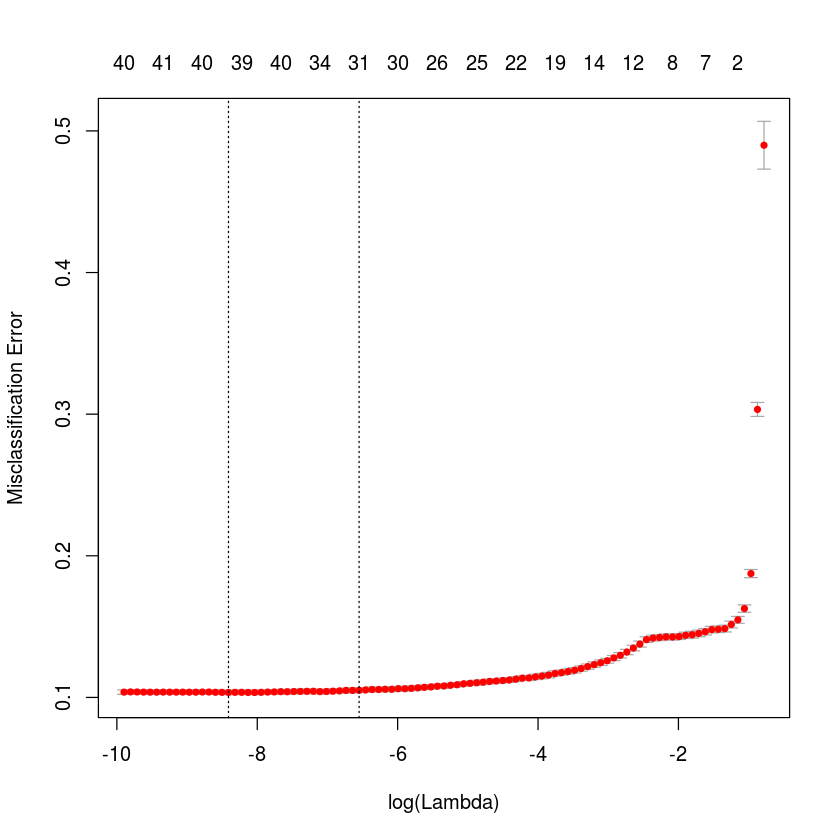

In [13]:
# Cross-validation curve
plot(weight.EN.fit)

# Estimated coefficients
coef(weight.EN.fit, s='lambda.1se')

# Confusion matrix
weight.EN.preds <- predict(weight.EN.fit, s='lambda.1se', model.matrix(Class ~., test.data), type='class')
weight.EN.CM <- confusionMatrix(as.factor(weight.EN.preds), test.data[, 1], positive=c('1'))
weight.EN.CM

# Sensitivity/specificity/precision/F1/accuracy
weight.EN.CM$byClass*100

# ROC curve
weight.EN.probs <- predict(weight.EN.fit, s='lambda.1se', model.matrix(Class ~., test.data), type='response')
weight.EN.roc <- roc(test.data[, 1], as.numeric(weight.EN.probs))

# Display area under the ROC curve
print('AUC')
weight.EN.roc$auc



### Classification Tree

Train a recursive partitioning tree using rpart.

In [14]:
t0 <- Sys.time()
weight.cart.fit <- rpart(Class ~.,
                         data=train.data,
                         weights = train.weights)
t1 <- Sys.time() - t0
t1

Time difference of 22.14959 secs

Show confusion matrix for test set, performance metrics, and plot the tree.

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 238336    819
         1  23906   3897
                                          
               Accuracy : 0.9074          
                 95% CI : (0.9063, 0.9085)
    No Information Rate : 0.9823          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.216           
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.82634         
            Specificity : 0.90884         
         Pos Pred Value : 0.14016         
         Neg Pred Value : 0.99658         
             Prevalence : 0.01767         
         Detection Rate : 0.01460         
   Detection Prevalence : 0.10415         
      Balanced Accuracy : 0.86759         
                                          
       'Positive' Class : 1               
                                          

Sensitivity          Specificity       Pos Pred Value 
            82.63359             90.88399             14.01647 
      Neg Pred Value            Precision               Recall 
            99.65754             14.01647             82.63359 
                  F1           Prevalence       Detection Rate 
            23.96753              1.76657              1.45978 
Detection Prevalence    Balanced Accuracy 
            10.41475             86.75879

[1] "AUC"


Area under the curve: 0.9025

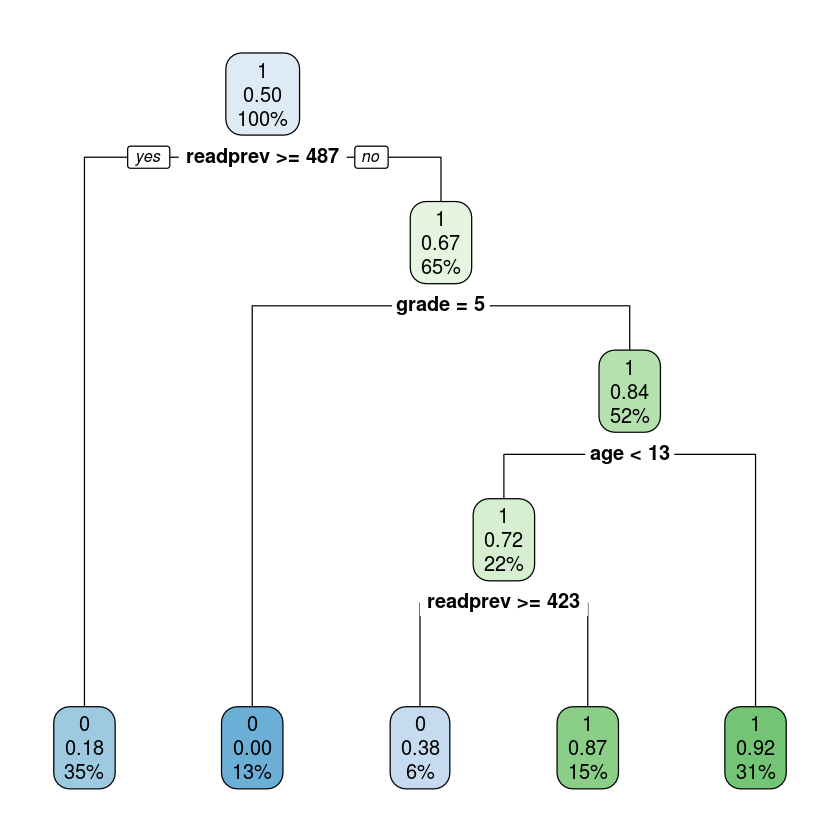

In [15]:
# Confusion matrix
weight.cart.preds <- predict(weight.cart.fit, newdata=test.data[, -1], type='class')
weight.cart.CM <- confusionMatrix(weight.cart.preds, test.data[, 1], positive="1")
weight.cart.CM
weight.cart.CM$byClass*100

# ROC curve
weight.cart.probs <- predict(weight.cart.fit, newdata=test.data[, -1])[, 2]
weight.roc <- roc(test.data[, 1], weight.cart.probs)
print('AUC')
weight.roc$auc


# Plot the tree
rpart.plot(weight.cart.fit,
           cex=1,
           fallen.leaves=T)


## SMOTE Classifiers

We balance the training set by generating a SMOTE sample using the out-of-the-box settings.

In [16]:
# Generate SMOTE sample
SMOTE.data <- SMOTE(Class ~., train.data)
dim(SMOTE.data)
summary(SMOTE.data)

# Turn into matrices
X <- model.matrix(Class ~., SMOTE.data)
y <- SMOTE.data$Class

[1] 66031    29

 Class     priv      grade          age        indig     mumschool mumhighed
 0:37732   0:36969   5:13518   Min.   : 9.00   0:58719   1: 5600   5:18735  
 1:28299   1:29062   7:24141   1st Qu.:12.10   1: 7312   2:14559   6:10324  
                     9:28372   Median :13.18             3: 8952   7:15475  
                               Mean   :13.01             4:36920   8:21497  
                               3rd Qu.:14.30                                
                               Max.   :17.50                                
 mumoccup  dadschool dadhighed dadoccup  sameschool    readprev    
 1:10024   1: 7300   5:24301   1:12264   0:26933    Min.   : 12.5  
 2:12011   2:17455   6: 8417   2:14908   1:39098    1st Qu.:404.7  
 3:14946   3: 8692   7:14184   3:16572              Median :453.2  
 4:11642   4:32584   8:19129   4:15438              Mean   :463.6  
 8:17408                       8: 6849              3rd Qu.:520.3  
                                                    M

### Elastic Net (SMOTE)

Now run the elastic net and tree, but without class weights this time.

In [17]:

# Estimate the elastic net classifier
t0 <- Sys.time()
set.seed(2718)
SMOTE.EN.fit <- cv.glmnet(x=X,
                          y=y,
                          family="binomial",
                          alpha=0.5,
                          type.measure="class",
                          parallel=T)
Sys.time() - t0

Time difference of 32.16299 secs

Display coefficients, CV curve, confusion matrix, performance measures.

45 x 1 sparse Matrix of class "dgCMatrix"
                          1
(Intercept)   -2.4466377715
(Intercept)    .           
priv1          0.0588418807
grade7         4.6041292125
grade9         4.9607143531
age            1.2172986076
indig1         1.4135074238
mumschool2    -0.0282826072
mumschool3     .           
mumschool4    -0.2547292047
mumhighed6     0.0036247119
mumhighed7    -0.1236533575
mumhighed8     .           
mumoccup2      .           
mumoccup3     -0.0909641878
mumoccup4      .           
mumoccup8      0.0213443330
dadschool2    -0.0741773638
dadschool3    -0.0180100705
dadschool4    -0.2612039751
dadhighed6     0.0078994357
dadhighed7    -0.0266869354
dadhighed8     0.0822617982
dadoccup2     -0.0440322651
dadoccup3      .           
dadoccup4      0.0403417312
dadoccup8      0.2254958356
sameschool1   -0.2742879474
readprev      -0.0214830563
mathprev      -0.0115614260
girl1         -0.1727958262
met1          -0.3478404069
provincial1    0.2364109996
remote

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 237346    692
         1  24896   4024
                                         
               Accuracy : 0.9041         
                 95% CI : (0.903, 0.9053)
    No Information Rate : 0.9823         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.2154         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.85327        
            Specificity : 0.90506        
         Pos Pred Value : 0.13914        
         Neg Pred Value : 0.99709        
             Prevalence : 0.01767        
         Detection Rate : 0.01507        
   Detection Prevalence : 0.10833        
      Balanced Accuracy : 0.87917        
                                         
       'Positive' Class : 1              
                                         

Sensitivity          Specificity       Pos Pred Value 
           85.326548            90.506479            13.914246 
      Neg Pred Value            Precision               Recall 
           99.709290            13.914246            85.326548 
                  F1           Prevalence       Detection Rate 
           23.926745             1.766570             1.507353 
Detection Prevalence    Balanced Accuracy 
           10.833165            87.916513

[1] "AUC"


Area under the curve: 0.9513

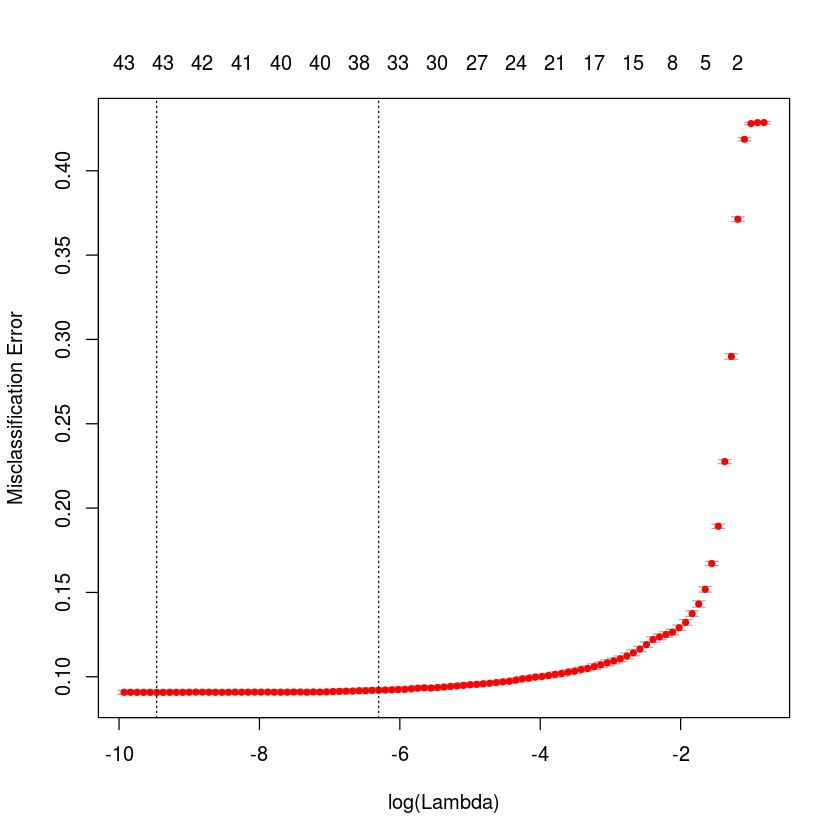

In [18]:
# Coefficients
coef(SMOTE.EN.fit, s='lambda.1se')

# Confusion matrix
SMOTE.EN.preds <- predict(SMOTE.EN.fit, s='lambda.1se', model.matrix(Class ~., test.data), type='class')
SMOTE.EN.CM <- confusionMatrix(as.factor(SMOTE.EN.preds), test.data[, 1], positive=c('1'))
SMOTE.EN.CM
SMOTE.EN.CM$byClass*100

# ROC curve
SMOTE.EN.probs <- predict(SMOTE.EN.fit, s='lambda.1se', model.matrix(Class ~., test.data), type='response')
SMOTE.EN.roc <- roc(test.data[, 1], as.numeric(SMOTE.EN.probs))

print('AUC')
SMOTE.EN.roc$auc

# CV curve
plot(SMOTE.EN.fit)


### Decision Tree (SMOTE)


In [19]:
t0 <- Sys.time()
SMOTE.cart.fit <- rpart(Class ~.,
                    data=SMOTE.data[, 1:29])
t1 <- Sys.time() - t0
t1


Time difference of 2.593009 secs

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 236159    820
         1  26083   3896
                                          
               Accuracy : 0.8992          
                 95% CI : (0.8981, 0.9004)
    No Information Rate : 0.9823          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2002          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.82612         
            Specificity : 0.90054         
         Pos Pred Value : 0.12996         
         Neg Pred Value : 0.99654         
             Prevalence : 0.01767         
         Detection Rate : 0.01459         
   Detection Prevalence : 0.11230         
      Balanced Accuracy : 0.86333         
                                          
       'Positive' Class : 1               
                                          

Sensitivity          Specificity       Pos Pred Value 
           82.612383            90.053843            12.995764 
      Neg Pred Value            Precision               Recall 
           99.653978            12.995764            82.612383 
                  F1           Prevalence       Detection Rate 
           22.458568             1.766570             1.459406 
Detection Prevalence    Balanced Accuracy 
           11.229856            86.333113

[1] "AUC"


Area under the curve: 0.8954

Warning message:
“Bad 'data' field in model 'call' (expected a data.frame or a matrix).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”

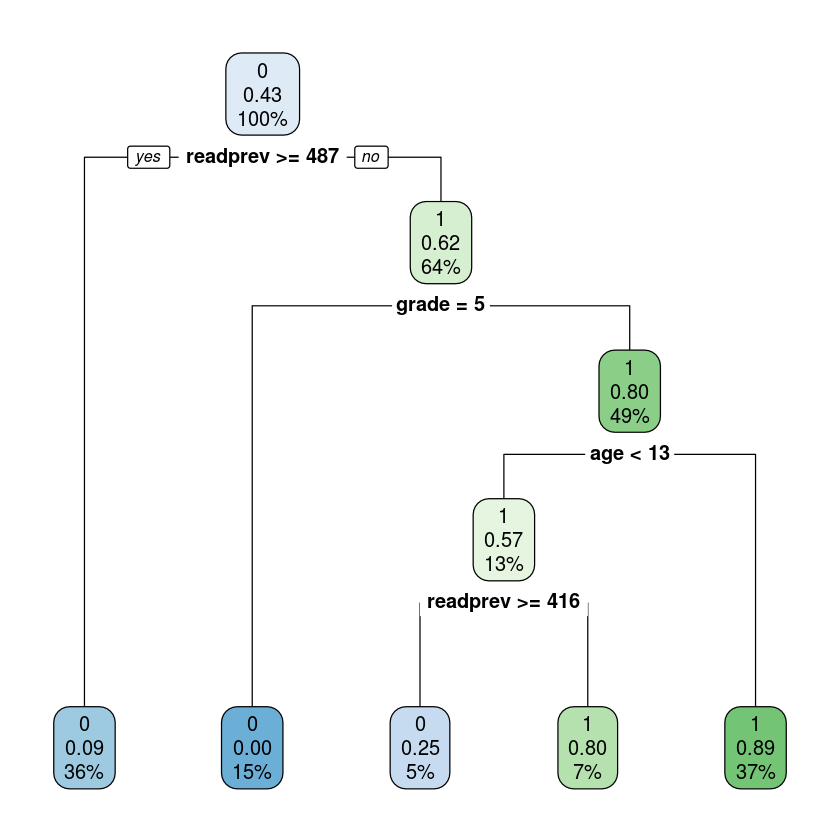

In [20]:
# Confusion Matrix
SMOTE.cart.preds <- predict(SMOTE.cart.fit, newdata=test.data[, -1], type='class')
SMOTE.cart.CM <- confusionMatrix(SMOTE.cart.preds, test.data[, 1], positive="1")
SMOTE.cart.CM
SMOTE.cart.CM$byClass*100

# ROC curve
SMOTE.cart.probs <- predict(SMOTE.cart.fit, newdata=test.data[, -1])[, 2]
SMOTE.cart.roc <- roc(test.data[, 1], SMOTE.cart.probs)
print("AUC")
SMOTE.cart.roc$auc

# Plot tree
rpart.plot(SMOTE.cart.fit,
           cex=1,
           fallen.leaves=T)


## Random Forest (SMOTE)

Now let's train a random forest on the SMOTE sample. Use an ensemble of 200 trees.



In [21]:
t0 <- Sys.time()
set.seed(2718)
rf.fit <- randomForest(x=X,
                       y=y,
                       ntree = 200)
Sys.time() - t0


Time difference of 1.2353 mins

png 
  2

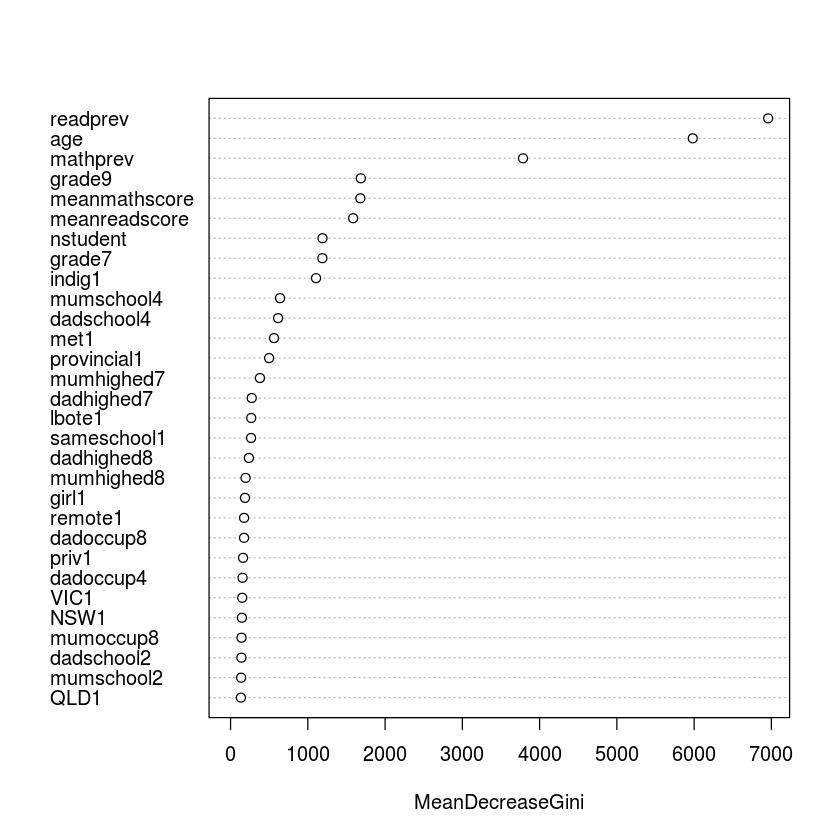

In [22]:
# Plot variable importance
setEPS()
postscript("RF_varimp_Lit_G5.eps", fonts=c('serif'))
varImpPlot(rf.fit, type=2, main="")
dev.off()

varImpPlot(rf.fit, type=2, main="")

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 242209    881
         1  20033   3835
                                          
               Accuracy : 0.9217          
                 95% CI : (0.9206, 0.9227)
    No Information Rate : 0.9823          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2461          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.81319         
            Specificity : 0.92361         
         Pos Pred Value : 0.16068         
         Neg Pred Value : 0.99638         
             Prevalence : 0.01767         
         Detection Rate : 0.01437         
   Detection Prevalence : 0.08941         
      Balanced Accuracy : 0.86840         
                                          
       'Positive' Class : 1               
                                          

Sensitivity          Specificity       Pos Pred Value 
           81.318914            92.360873            16.067538 
      Neg Pred Value            Precision               Recall 
           99.637583            16.067538            81.318914 
                  F1           Prevalence       Detection Rate 
           26.833193             1.766570             1.436556 
Detection Prevalence    Balanced Accuracy 
            8.940732            86.839894

[1] "AUC"


Area under the curve: 0.9521

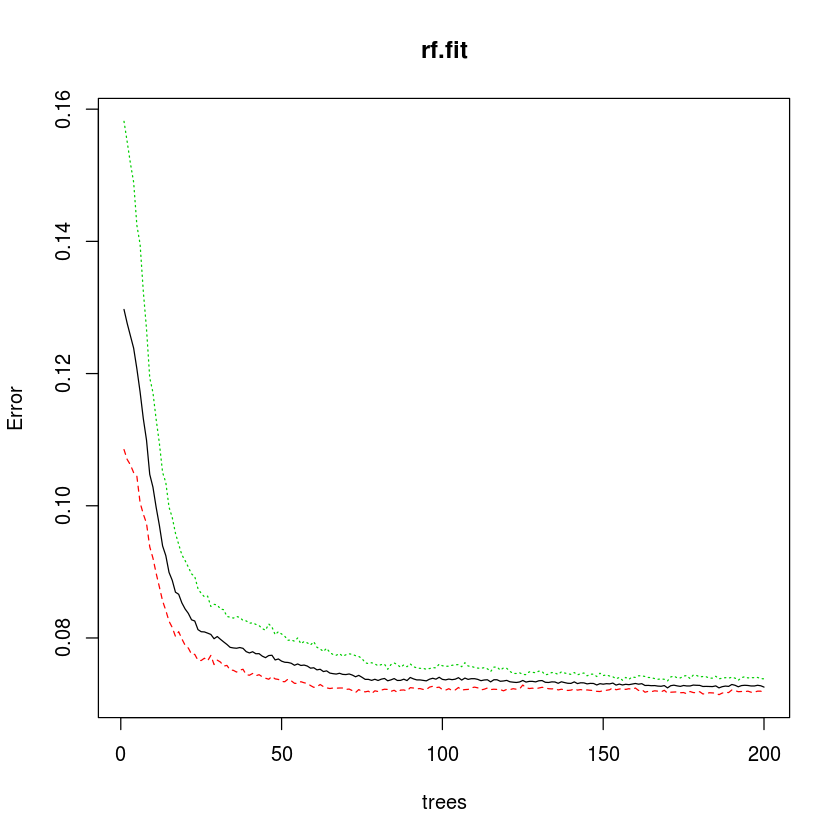

In [23]:
# Confusion matrix
rf.preds <- predict(rf.fit, newdata=model.matrix(Class ~., test.data), type='class')
rf.CM <- confusionMatrix(rf.preds, test.data[, 1], positive="1")
rf.CM
rf.CM$byClass*100

# ROC curve
SMOTE.rf.probs <- predict(rf.fit, newdata=model.matrix(Class ~., test.data), type='prob')[, 2]
SMOTE.rf.roc <- roc(test.data[, 1], SMOTE.rf.probs)
print("AUC")
SMOTE.rf.roc$auc

# Plot the random forest training curves
plot(rf.fit)


## ROC Curves

We've saved the individual ROC curves for each of the 5 classifiers. Let's plot them all together on the one graph. First get all the data together in a data frame for ggplot2.

In [24]:
weight.EN.roc.df <- data.frame(Sens=weight.EN.roc$sensitivities, Spec=weight.EN.roc$specificities, Classifier='Weighted EN')
weight.roc.df <- data.frame(Sens=weight.roc$sensitivities, Spec=weight.roc$specificities, Classifier='Weighted Tree')
SMOTE.EN.roc.df <- data.frame(Sens=SMOTE.EN.roc$sensitivities, Spec=SMOTE.EN.roc$specificities, Classifier='SMOTE EN')
SMOTE.cart.roc.df <- data.frame(Sens=SMOTE.cart.roc$sensitivities, Spec=SMOTE.cart.roc$specificities, Classifier='SMOTE Tree')
SMOTE.rf.roc.df <- data.frame(Sens=SMOTE.rf.roc$sensitivities, Spec=SMOTE.rf.roc$specificities, Classifier='SMOTE RF')


# For some reason the Elastic Net ROC curves have a huge number of data points.
# Down sample them in order to plot the ROC curve
ix <- sample(nrow(weight.EN.roc.df), 50, replace = F)
weight.EN.roc.df <- weight.EN.roc.df[ix, ]
ix <- sample(nrow(SMOTE.EN.roc.df), 50, replace = F)
SMOTE.EN.roc.df <- SMOTE.EN.roc.df[ix, ]

all.rocs <- rbind(weight.EN.roc.df,
                  weight.roc.df,
                  SMOTE.EN.roc.df,
                  SMOTE.cart.roc.df,
                  SMOTE.rf.roc.df)



Now plot the curves.

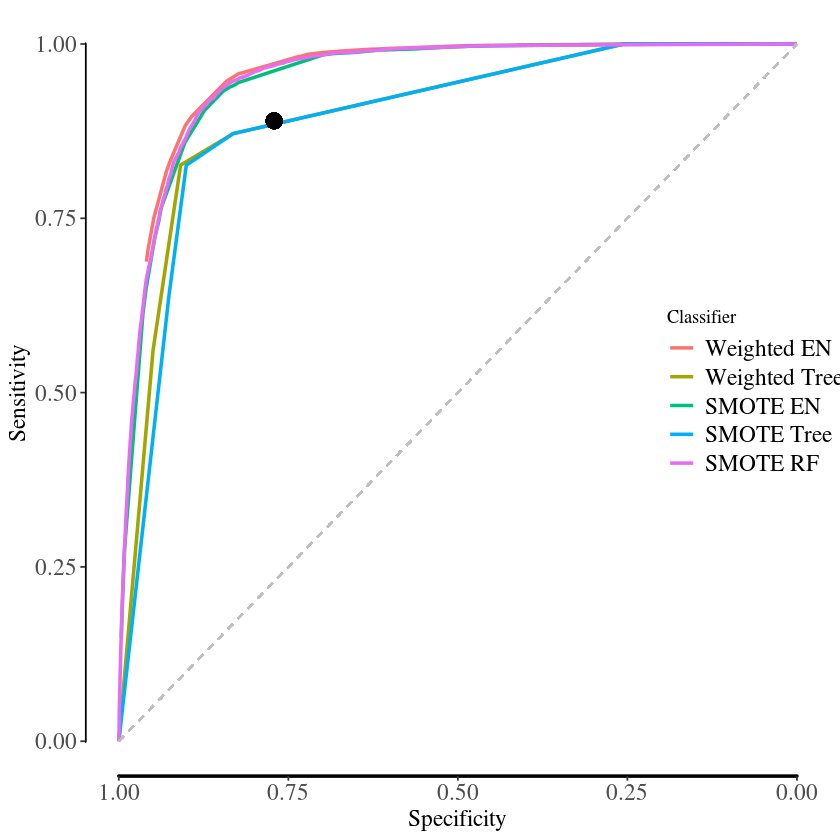

In [25]:
ROC1 <- ggplot(data=all.rocs, aes(x=Spec, y=Sens, color=Classifier)) +  
      geom_line(stat='identity', cex=1)+
      scale_x_reverse() + 
      geom_rangeframe(color='black', cex=1) + 
      theme_tufte() + 
      xlab('Specificity') + 
      ylab('Sensitivity') + 
      geom_segment(aes(x = 1, xend = 0, y = 0, yend =1), linetype='dashed', color='grey', size=0.5)+
      theme (axis.text.x = element_text(size=14),
         axis.text.y = element_text(size=14),
         axis.title = element_text(size=14),
         legend.text = element_text(size=14),
         legend.position = c(.9, .5))+
      geom_point(aes(x=naive.CM$byClass[1], y=naive.CM$byClass[2]), color='black', cex=4)
ROC1

## Cleaning Up

Let's put the relevant outputs into a clean form so that they can be copied into the paper. 

Start by saving our decision trees and ROC curve to disk in postscript format.


In [26]:
# Weighted tree
setEPS()
postscript("Lit_Weighted_Tree.eps", width=23, height=10, pointsize=12)
rpart.plot(weight.cart.fit,
           cex=1.5,
           fallen.leaves=T)
dev.off()

# Smote tree
setEPS()
postscript("Lit_Smote_Tree.eps", width=23, height=10, pointsize=12)
rpart.plot(SMOTE.cart.fit,
           cex=1.5,
           fallen.leaves=T)
dev.off()

setEPS()
postscript("ROC_Lit.eps", fonts=c('serif'))
ROC1
dev.off()



png 
  2

Warning message:
“Bad 'data' field in model 'call' (expected a data.frame or a matrix).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”

png 
  2

png 
  2

Next, we'll prep the elastic net coefficients. We want a LaTeX table with five columns: 1) variable names; 2)literacy/weighted coefficients; 3) literacy SMOTE coefs; 4) numeracy weighted; 5) numeracy SMOTE.

Let's stick the variable names, literacy weighted, and literacy SMOTE data into a data frame which we can load when the numeracy results are finished. Then we'll save the whole thing in one LaTeX table.

In [27]:
# Weighted EN
Cw <- coef(weight.EN.fit)

# Extract variable names.
var.names <- row.names(Cw)

# Round the coefficients to 2SF.
Cw <- round(Cw[, 1], 2)

# SMOTE EN
Cs <- coef(SMOTE.EN.fit)
Cs <- round(Cs[, 1], 2)

EN <- data.frame(Variable=var.names, Weighted=Cw, SMOTE=Cs)

# Note that there are two instances of 'intercept'. 
# Remove the second.
EN <- EN[-2, ]

# All set. Once the numeracy numbers are done,
# we'll just cbind them into the data frame 
# and save them with xtable.
save(EN, file='ElasticNetCoefs.Rda')

Finally, save the workspace, and we're all done.

In [28]:
save.image('literacy_workspace.RData')
print('Finished.') 
Sys.time() - start.time

[1] "Finished."


Time difference of 13.4395 mins